## 고차 미분 지원

In [19]:
# dezero.core.py

class Config: # 역전파 활성화 모드
  enable_backprop=True
  #  함수들
import contextlib
import numpy as np
@contextlib.contextmanager
def using_config(name, value):
  old_value=getattr(Config, name)
  setattr(Config, name, value)
  try:
    yield # 컨텍스트 블록 실행 (이 부분에서 실행 흐름이 사용자 코드로 넘어감)
  finally:
    setattr(Config, name, old_value)

def no_grad():
  return using_config('enable_backprop',False)

def as_array(x):
  if np.isscalar(x): #numpy.float64같은 스칼라타입인지 확인
    return np.array(x)
  return x

def as_variable(obj): # np인스턴스와 함꼐 입력되도 오류없이 수행
  if isinstance(obj, Variable):
    return obj
  return Variable(obj)

import weakref

class Variable:
  __array_priority__=200
  def __init__(self, data, name=None):
    if data is not None:
      if not isinstance(data,np.ndarray):
        raise TypeError("{}은 지원 불가".format(type(data)))
    self.data=data
    self.name=name # 많은 변수 처리 -> 이름 필요 -> 인스턴스 변수 추가
    self.grad=None
    self.creator=None
    self.generation=0

  def set_creator(self, func):
    self.creator=func
    self.generation=func.generation+1 # 부모 세대 함수보다 1만큼 큰 값 설정

  def backward(self, retain_grad=False, create_graph=False): # retain_grad: 필요 없는 미분값 삭제 / 보통 말단 변수 미분값만이 필요
    if self.grad is None:
      self.grad=Variable(np.ones_like(self.data)) # 고차 미분 구현 위해 Variable class로 감쌈

    funcs=[]
    seen_set=set()
    def add_func(f):
      if f not in seen_set:
        funcs.append(f)
        seen_set.add(f)
        funcs.sort(key=lambda x:x.generation)

    add_func(self.creator)

    while funcs:
      f=funcs.pop()
      gys=[output().grad for output in f.outputs] #약한 참조로 바꿨으므로 ()추가하여 수정

      # 역전파를 단 한번만 수행하게 수정
      with using_config('enable_backprop', create_graph): # 역전파 비활성 모드로 역전파 처리 생략 (계산그래프 생성/입력 변수 유지 등 생략)
        gxs=f.backward(*gys) # 메인 역전파 (Var끼리의 연산으로 바꾸었기 때문에 f.backward내에서 순전파 실행됨. 이때 연결 생성되는데, creat_graph인수로 이를 막음. 고차 미분 시행시는 이 인수를True로 둔다)
        # gx*x1 등 불필요한 고차 미분시의 연결을 사전에 차단하는 방식.
        if not isinstance(gxs, tuple):
         gxs=(gxs,)
        for x, gx in zip(f.inputs, gxs):
          if x.grad is None:
            x.grad=gx
          else:
            x.grad = x.grad + gx
          if x.creator is not None:
            add_func(x.creator)

      if not retain_grad: # 말단 변수 아닐시 미분값 삭제
        for y in f.outputs:
          y().grad=None

  def cleargrad(self):
    self.grad=None

  # 목표: Variable을 ndarray처럼 보이게 만드는 것
  @property # 인스턴스 변수처럼 사용할수 있게 함 x.shape() -> x.shape
  def shape(self):
    return self.data.shape

  @property
  def ndim(self):
    return self.data.ndim

  @property
  def size(self):
    return self.data.size

  @property
  def dtype(self):
    return self.data.dtype

  def __len__(self): # 특수 메서드
    return len(self.data)

  def __repr__(self): # print함수 출력값 수정하려면  __repr__재정의
    if self.data is None:
      return 'variable(None)'
    p=str(self.data).replace('\n','\n'+''*9)
    return 'variable('+p+')'

  # # 함수식 거추장-> 연산자 오버로드
  # def __mul__(self, other): #self=a전달, other=b전달
  #   return mul(self, other)

class Function:
  def __call__(self, *inputs):
    inputs=[as_variable(x) for x in inputs]
    xs=[x.data for x in inputs]
    ys=self.forward(*xs)
    if not isinstance(ys, tuple):
      ys=(ys,)
    outputs=[Variable(as_array(y)) for y in ys]

    if Config.enable_backprop: # 역전파 모드에서만 연결 연산 수행
      # 입력 변수 세대중에 가장 큰 세대 값으로 함수의 세대 설정
      self.generation=max([x.generation for x in inputs])
      for output in outputs:
        output.set_creator(self)
      self.inputs=inputs
      self.outputs=[weakref.ref(output) for output in outputs] # 약한 참조로 수정

    return outputs if len(outputs)>1 else outputs[0]

  def forward(self, xs):
    raise NotImplementedError()

  def backward(self, gys):
    raise NotImplementedError()

class Square(Function):
  def forward(self, x):
    y=x**2
    return y
  def backward(self, gy):
    x=self.inputs[0].data
    gx=2*x*gy
    return gx

class Add(Function):
  def forward(self, x0,x1):
    y=x0+x1
    return y
  def backward(self, gy):
    return gy,gy #상류에서 흘러오는 미분값을 그대로 흘려보내는 것이 덧셈의 역전파(미분시, gy*1이라서)

def square(x):
  return Square()(x)
def add(x0,x1):
  x1=as_array(x1) #x1가 float등일 경우 ndarray인스턴스로 변환
  return Add()(x0,x1)

class Mul(Function):
  def forward(self, x0, x1):
    y=x0*x1
    return y

  def backward(self, gy):
    x0, x1=self.inputs[0], self.inputs[1] # x0, x1은 Variable class (gy 도)
    return gy*x1, gy*x0 # Variable class의 *연산자는 이미 오버로드 되어있어 순전파 호출

def mul(x0,x1):
  x1=as_array(x1) #x1가 float등일 경우 ndarray인스턴스로 변환
  return Mul()(x0,x1)



class Neg(Function):
  def forward(self,x):
    return -x
  def backward(self, gy):
    return -gy
def neg(x):
  return Neg()(x)

class Sub(Function):
  def forward(self, x0,x1):
    return x0-x1
  def backward(self, gy):
    return gy,-gy

def sub(x0,x1):
  x1=as_array(x1)
  return Sub()(x0,x1)

def rsub(x0,x1):
  x1=as_array(x1)
  return Sub()(x1,x0)

class Div(Function):
  def forward(self, x0,x1):
    y=x0/x1
    return y
  def backward(self, gy):
    x0,x1=self.inputs[0], self.inputs[1]
    return gy*(1/x1), gy*(-x0/x1**2)

def div(x0,x1):
  x1=as_array(x1)
  return Div()(x0,x1)

def rdiv(x0,x1):
  x1=as_array(x1)
  return Div()(x1,x0)

class Pow(Function):
  def __init__(self, c):
    self.c=c
  def forward(self, x):
    y=x**self.c
    return y
  def backward(self, gy):
    x=self.inputs[0]
    return gy*(self.c*x**(self.c-1))

def pow(x,c):
  x=as_array(x)
  return Pow(c)(x)

def setup_variable():
  Variable.__add__=add
  Variable.__radd__=add
  Variable.__mul__=mul
  Variable.__rmul__=mul
  Variable.__rsub__=rsub
  Variable.__sub__=sub
  Variable.__neg__=neg
  Variable.__truediv__=div
  Variable.__rtruediv__=rdiv
  Variable.__pow__=pow

setup_variable()

In [47]:
# dezero/functions.py

# Sin함수 구현
class Sin(Function):
  def forward(self,x):
    y=np.sin(x)
    return y
  def backward(self, gy):
    x,=self.inputs # self.inputs[0] 대신 간단하게 사용
    gx=cos(x)*gy  # dezero의 cos
    return gx
def sin(x):
  return Sin()(x)

# Cos함수 구현
class Cos(Function):
  def forward(self, x):
    return np.cos(x)
  def backward(self, gy):
    x,=self.inputs
    return gy*-sin(x)
def cos(x):
  return Cos()(x)

# tanh 함수 구현
class Tanh(Function):
  def forward(self,x):
    y=np.tanh(x)
    return y
  def backward(self, gy):
    y=self.outputs[0]()
    return gy*(1-y**2)
def tanh(x):
  return Tanh()(x)

In [43]:
# n차 sin미분
x=Variable(np.array(1.0))
y=sin(x)
y.backward(create_graph=True)
print(x.grad)

for i in range(3):
  gx=x.grad
  x.cleargrad()
  gx.backward(create_graph=True)
  print(x.grad)


variable(0.5403023058681398)
variable(-0.8414709848078965)
variable(-0.5403023058681398)
variable(0.8414709848078965)


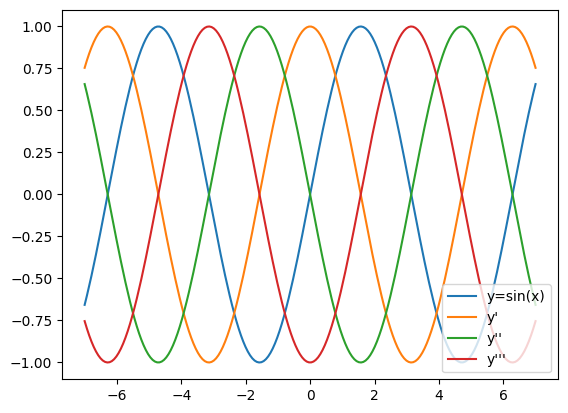

In [46]:
x=Variable(np.linspace(-7, 7, 200)) #-7부터 7까지 200개의 균등한 값
y=sin(x)
y.backward(create_graph=True)

logs=[y.data]

for i in range(3):
  logs.append(x.grad.data)
  gx=x.grad
  x.cleargrad()
  gx.backward(create_graph=True)

labels=["y=sin(x)","y'","y''","y'''"]

import matplotlib.pyplot as plt
for i, v in enumerate(logs):
  plt.plot(x.data,logs[i],label=labels[i])
plt.legend(loc='lower right')

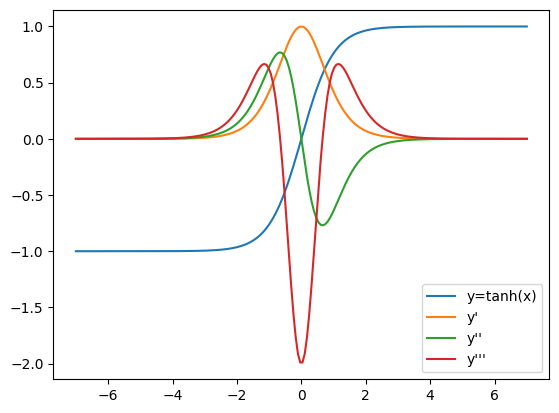

In [48]:
x=Variable(np.linspace(-7, 7, 200)) #-7부터 7까지 200개의 균등한 값
y=tanh(x)
y.backward(create_graph=True)

logs=[y.data]

for i in range(3):
  logs.append(x.grad.data)
  gx=x.grad
  x.cleargrad()
  gx.backward(create_graph=True)

labels=["y=tanh(x)","y'","y''","y'''"]

import matplotlib.pyplot as plt
for i, v in enumerate(logs):
  plt.plot(x.data,logs[i],label=labels[i])
plt.legend(loc='lower right')

In [50]:
# 고차 미분 이외의 용도-미분 식을 구하고, 그 식 사용해 계산 후, 다시 미분
# double backprop
x=Variable(np.array(2.0))
y=x**2
y.backward(create_graph=True)
gx=x.grad

x.cleargrad()
z=gx**3+y
z.backward()
print(x.grad)

variable(100.0)


## 테일러 급수 미분

In [20]:
# Sin함수 만들기
class Sin(Function):
  def forward(self,x):
    y=np.sin(x)
    return y
  def backward(self, gy):
    x=self.inputs[0].data
    return np.cos(x)*gy
def sin(x):
  return Sin()(x)

x=Variable(np.array(np.pi/4))
y=sin(x)
y.backward()

print(y.data)
print(x.grad)

0.7071067811865475
variable(0.7071067811865476)


In [21]:
import math
# define by run의 사용 편의성
def my_sin(x,threshold=0.0001):
  y=0
  for i in range(100000):
    c=(-1)**i/math.factorial(2*i+1)
    t=c*x**(2*i+1) #x가 Var타입이므로 t도 저절로
    y=y+t
    if abs(t.data)<threshold:
      break
  return y

x=Variable(np.array(np.pi/4))
y=my_sin(x)
y.backward()

print(y.data)
print(x.grad)

0.7071064695751781
variable(0.7071032148228457)


## 함수 최적화

## 뉴턴 방식으로 푸는 최적화(수동미분)


In [31]:
# 뉴턴 방법은 경사하강법을 대체할 수 있는, 수렴이 더 빠른 방법
# 경사하강법: 속도(1계도)만 이용
# 뉴턴방법: 속도(1계도)+ 가속도(2계도)
import numpy as np

def f(x):
  y=x**4-2*x**2
  return y

def gx2(x): # 수동으로 2차미분 구함(고차미분지원X)
  return 12*x**2-4

x=Variable(np.array(2.0))
iters=10

for i in range(iters):
  print(i, x)
  y=f(x)
  x.cleargrad()
  y.backward()

  x-=x/gx2(x)

# 최솟값 중 하나인 1에 가까워지는것을 알 수 있다.(경사하강법보다 훨씬 빠르게 도달)

0 variable(2.0)
1 variable(1.9545454545454546)
2 variable(1.90783401863789)
3 variable(1.8597510615549389)
4 variable(1.810163105835651)
5 variable(1.7589131492398136)
6 variable(1.7058143742264829)
7 variable(1.6506415082757346)
8 variable(1.5931186645524813)
9 variable(1.5329017346714748)


## 뉴턴 방법으로 푸는 최적화(자동미분수정)

In [27]:
x=Variable(np.array(2.0))
y=f(x)
y.backward(create_graph=True) # 이차 미분 사용 위함
print(x.grad)
# 두번째 역전파
gx=x.grad
x.cleargrad() # 없으면 기존 미분값에 더해짐
gx.backward()
print(x.grad)



variable(24.0)
variable(44.0)


In [38]:
x=Variable(np.array(2.0))
iters=10

for i in range(iters):
  print(i,x)

  y=f(x)
  x.cleargrad()
  y.backward(create_graph=True)

  gx=x.grad
  x.cleargrad()
  gx.backward()
  gx2=x.grad

  x.data-=gx.data/gx2.data

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)
